In [1]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
import h5py, io, copy, gc, time
from numba import njit

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175 - 0.049 , Omega_b = 0.049, h=0.6711, sigma8=0.82, n_s=0.9649,
                      matter_power_spectrum='linear')
h = cosmo.cosmo.params.h

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar = dict(alpha_g = 2, epsilon_h = 0.015, M1_0 = 2.2e11/h, alpha_sat = 1,
            M_c = 1.2e14/h, eta = 0.6, mu = 0.31, beta = 0.6, epsilon_hydro = np.sqrt(5),
            M_inn = 3.3e13/h,
            M_r = 1e30, beta_r = 2, theta_inn = 0.1, theta_out = 1,
            theta_rg = 0.3, sigma_rg = 0.1, a = 0.3, n = 2, p = 0.3, q = 0.707)

In [2]:
#Convenience function for histogram things quickly

@njit
def numba_histogram3d(points, bins, min_vals, max_vals):
    counts = np.zeros((bins, bins, bins), dtype=np.int64)
    bin_width = (max_vals - min_vals) / bins

    for i in range(points.shape[0]):
        ix = int((points[i, 0] - min_vals) / bin_width)
        iy = int((points[i, 1] - min_vals) / bin_width)
        iz = int((points[i, 2] - min_vals) / bin_width)
        
        counts[ix, iy, iz] += 1

    return counts

# First download TNG data

In [3]:
import requests #or do "pip install requests"

#You need a TNG API key. Sign-up for an account here: https://www.tng-project.org/data/
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key" : open('../../TNG_API_KEY.txt', 'r').readline().strip()}

In [4]:
def get(path, params=None):
    
    r = requests.get(path, params=params, headers=headers, stream=True)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json': return r.json()
    
    return r

In [5]:
####################################
#STEP 1: Get all the particle data
####################################
p = f"{os.environ['SCRATCH']}/TNG300-3-Dark-particles.npy"
if os.path.isfile(p):    
    print("LOADING EXISTING FILE FOR DM PARTICLES")
    particles = np.load(p)

else:
    particles    = []
    sim_metadata = get("http://www.tng-project.org/api/TNG300-3-Dark/")
    for i in range(sim_metadata['num_files_snapshot']):

        file_url       = base_url + "files/snapshot-99." + str(i) + ".hdf5"
        saved_filename = get(file_url, {'dm':'Coordinates'})

        with h5py.File(io.BytesIO(saved_filename.content), 'r') as f:
            particles.append(
                f['PartType1']['Coordinates'][:] * 1e-3/h #from kpc/h to Mpc
            )

        print("DONE WITH CHUNK", i)
    
    particles = np.concatenate(particles, axis = 0, dtype = np.float32)
    np.save(p, particles)
    
####################################
#STEP 1: Get all the Halo mass
####################################
p = f"{os.environ['SCRATCH']}/TNG300-3-Dark-HaloMass.npy"
if os.path.isfile(p):
    print("LOADING EXISTING FILE FOR HALO MASS")
    HaloMass = np.load(p)
else:
    saved_filename = get(base_url + "files/groupcat-99/", {'Group':'Group_M_Crit200'})
    with h5py.File(io.BytesIO(saved_filename.content), 'r') as f:
        HaloMass = f['Group']['Group_M_Crit200'][:] * 1e10/h #from 1e10/h Msun --> Msun

p = f"{os.environ['SCRATCH']}/TNG300-3-Dark-HaloPos.npy"
if os.path.isfile(p):
    print("LOADING EXISTING FILE FOR HALO POS")
    HaloPos = np.load(p)
else:
    saved_filename = get(base_url + "files/groupcat-99/", {'Group':'GroupCM'})
    with h5py.File(io.BytesIO(saved_filename.content), 'r') as f:
        HaloPos = f['Group']['GroupCM'][:] * 1e-3/h #from kpc/h --> Mpc

LOADING EXISTING FILE FOR DM PARTICLES
LOADING EXISTING FILE FOR HALO MASS
LOADING EXISTING FILE FOR HALO POS


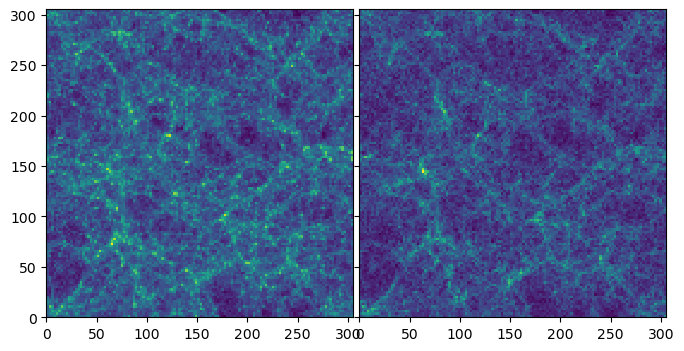

In [6]:
#Just a quick plot to show the structure is totally consistent amongst the two
bins = np.linspace(0, 205/h, 128 + 1)

import matplotlib as mpl
fig, ax = plt.subplots(1, 2, figsize = (8, 4), sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.02)

ax[0].hist2d(particles[:, 0], particles[:, 1], bins = bins, norm = mpl.colors.LogNorm())
ax[1].hist2d(HaloPos[:, 0], HaloPos[:, 1], bins = bins)

plt.show()

# Setup the runners

In [7]:
cdict = bfg.misc.build_cosmodict(cosmo)

Mask  = HaloMass > np.power(10, 12.8)
HCat  = bfg.HaloNDCatalog(x = HaloPos[:, 0][Mask],
                          y = HaloPos[:, 1][Mask], 
                          z = HaloPos[:, 2][Mask], 
                          M = HaloMass[Mask], redshift = 0, cosmo = cdict)

Snap  = bfg.ParticleSnapshot(x = particles[:, 0], 
                             y = particles[:, 1],
                             z = particles[:, 2], 
                             L = 205/h,
                             redshift = 0, cosmo = cdict)

In [8]:
#Model is "None" just so we setup the KDTree first. We will populate the model var later, as we swap through params
Runner = bfg.Runners.BaryonifySnapshot(HCat, Snap, epsilon_max = 1.2, model = None, 
                                       KDTree_kwargs = {'leafsize' : 1e3, 'balanced_tree' : False, 'compact_nodes' : False})

In [9]:
#Create the particle set for the snapshot already
Part_D = np.array([Snap.cat[x][:] for x in 'xyz']).T

#Setup the other params as well, mainly the grids, since we only use it once
Ngrd   = 256
Nk     = 180
Lbox   = Snap.L
kbins  = np.linspace(2*np.pi/Lbox, 2*np.pi/Lbox * Ngrd/2, Nk + 1)
klin   = np.fft.fftfreq(Ngrd, 1 / (2*np.pi/(Lbox)) / Ngrd)
k      = np.sqrt(klin[:, None, None]**2 + klin[None, None, :]**2 + klin[None, :, None]**2).flatten()
kinds  = np.floor((k - kbins[0]) / (kbins[1] - kbins[0])).astype(int)
kmsk   = (kinds >= 0) & (kinds < Nk)
k_c    = np.bincount(kinds[kmsk], minlength = Nk)
k_cen  = np.bincount(kinds[kmsk], minlength = Nk, weights = k[kmsk]) / k_c

In [10]:
del particles, k; gc.collect();

# Now do M_c

Building Table:   0%|          | 0/2 [00:00<?, ?it/s]/home/dhayaa/Desktop/Quijote/BaryonForge/examples/../BaryonForge/Profiles/Arico20.py:854: UserWarning: Increase integral lower limit, r_min_int (10.0) < minimum radius (100.0)
  warnings.warn(f"Increase integral lower limit, r_min_int ({self.r_max_int}) < minimum radius ({np.max(r)})", UserWarning)
/home/dhayaa/Desktop/Quijote/BaryonForge/examples/../BaryonForge/Profiles/Arico20.py:854: UserWarning: Increase integral lower limit, r_min_int (10.0) < minimum radius (1200.0)
  warnings.warn(f"Increase integral lower limit, r_min_int ({self.r_max_int}) < minimum radius ({np.max(r)})", UserWarning)
Building Table: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


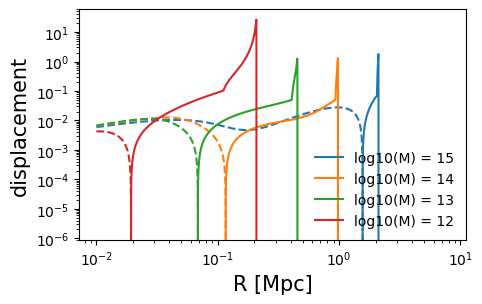

Baryonifying matter: 100%|██████████| 7088/7088 [00:37<00:00, 189.37it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 1490090895.5446281
09:28:13
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 1490090895.5446281
09:28:48


Building Table:   0%|          | 0/2 [00:00<?, ?it/s]/home/dhayaa/Desktop/Quijote/BaryonForge/examples/../BaryonForge/Profiles/Arico20.py:854: UserWarning: Increase integral lower limit, r_min_int (10.0) < minimum radius (100.0)
  warnings.warn(f"Increase integral lower limit, r_min_int ({self.r_max_int}) < minimum radius ({np.max(r)})", UserWarning)
/home/dhayaa/Desktop/Quijote/BaryonForge/examples/../BaryonForge/Profiles/Arico20.py:854: UserWarning: Increase integral lower limit, r_min_int (10.0) < minimum radius (1200.0)
  warnings.warn(f"Increase integral lower limit, r_min_int ({self.r_max_int}) < minimum radius ({np.max(r)})", UserWarning)
Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


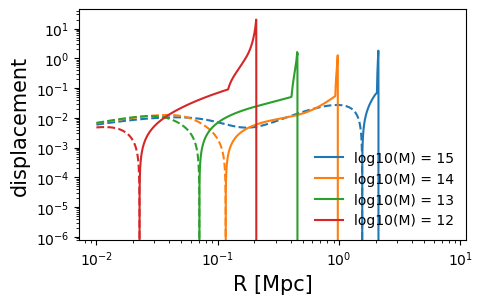

Baryonifying matter: 100%|██████████| 7088/7088 [00:38<00:00, 183.96it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 149009089554.46283
09:30:32
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 149009089554.46283
09:30:50


Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


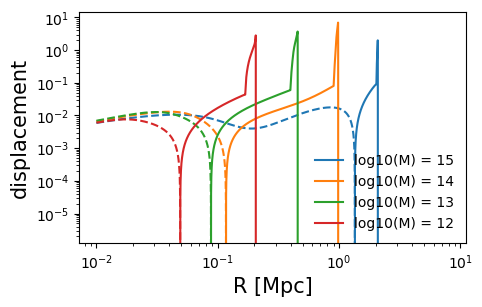

Baryonifying matter: 100%|██████████| 7088/7088 [00:36<00:00, 192.53it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 14900908955446.281
09:32:25
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 14900908955446.281
09:32:43


Building Table: 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


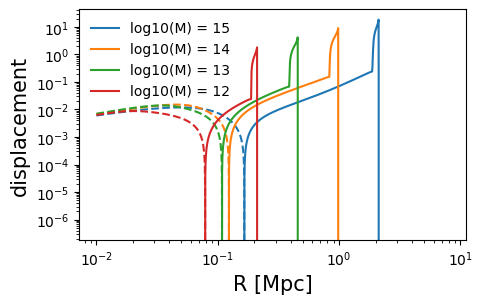

Baryonifying matter: 100%|██████████| 7088/7088 [00:37<00:00, 188.16it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 1490090895544628.2
09:34:23
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 1490090895544628.2
09:34:39


In [11]:
RES_M_c = {'DM' : {}}

for param in [1e9/h, 1e11/h, 1e13/h, 1e15/h]:
    
    RES_M_c[param] = {}
    
    tmp = copy.deepcopy(bpar)
    tmp['M_c'] = param
    DMO = bfg.Profiles.Arico20.DarkMatterOnly(**tmp)
    DMB = bfg.Profiles.Arico20.DarkMatterBaryon(**tmp)

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfg.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = 2)
    Displacement.setup_interpolator(z_min = 0, z_max = 0.01, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 20_000, verbose = True, Rdelta_sampling = True)
    
    #Plot to show
    R = np.geomspace(0.01, 8, 10_000)
    plt.figure(figsize = (5,3)); plt.loglog()
    for M in [1e15, 1e14, 1e13, 1e12]: 
        c = plt.plot(R, Displacement.displacement(R, M, 1), label = 'log10(M) = %d' % np.log10(M))
        plt.plot(R, -Displacement.displacement(R, M, 1),color = c[0].get_color(), ls = '--')
    
    plt.ylabel('displacement', size = 15); plt.xlabel('R [Mpc]', size = 15); plt.legend(frameon = False)
    plt.show()
    
    #Swap in the new model into the Snapshot runner
    #And run the map!
    Runner.model    = Displacement
    Baryonified_Map = Runner.process()
    
    #Baryonified particle set
    Part_B = np.array([Baryonified_Map[x][:] for x in 'xyz']).T
    del Baryonified_Map; gc.collect()

    for factor in [1, 8]:

        Lbox = Snap.L / factor
        bins = np.linspace(0, Lbox, Ngrd + 1)
        
        MapB = numba_histogram3d(Part_B % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
        FFTB = np.fft.fftn(MapB); del MapB; gc.collect()
        FFTB = (np.conjugate(FFTB) * FFTB).real.flatten()
        PkB  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTB[kmsk]) / k_c; del FFTB; gc.collect()
        
        if f'Factor{factor}' not in RES_M_c['DM'].keys():
            MapD = numba_histogram3d(Part_D % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
            FFTD = np.fft.fftn(MapD);  del MapD; gc.collect()
            FFTD = (np.conjugate(FFTD) * FFTD).real.flatten()
            PkD  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTD[kmsk]) / k_c; del FFTD; gc.collect()
            RES_M_c['DM'][f'Factor{factor}'] = PkD
            
        else:
            PkD = RES_M_c['DM'][f'Factor{factor}']

        
        RES_M_c[param][f'Factor{factor}'] = {'k' : k_cen * factor, 'S' : PkB/PkD}
        
        print(f"FINISHED P(k) WITH FOLDING FACTOR {factor} FOR PARAM VALUE {param}")
        print(time.strftime("%H:%M:%S", time.localtime()))
        
    del Part_B; gc.collect()

Text(0.5, 0, '$k$  [$\\rm 1/Mpc$]')

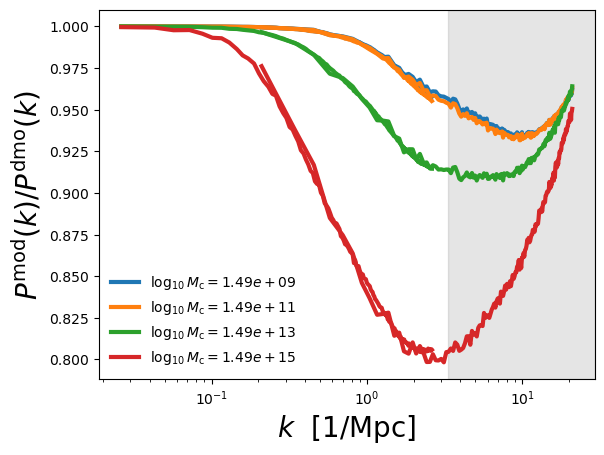

In [12]:
plt.xscale('log')

keys = [k for k in RES_M_c.keys() if not isinstance(k, str)]
for i in range(len(keys)):
    R = RES_M_c[keys[i]]
    for k in R.keys():
        plt.plot(R[k]['k'], R[k]['S'], color = f'C{i}', lw = 3, 
                 label = r'$\log_{10}M_{\rm c} = %0.2e$' % keys[i] if k == list(R.keys())[0] else None)
    
    #Some hacking to get the right key from dataframe
    k = str(int(keys[i] * h))
    k = f"Mc{'2p5' if k.replace('0','') == '25' else k.replace('0','')}e{np.max([k.count('0'), 13])}"
    
xlim = plt.xlim()
plt.axvspan(5*h, xlim[1], color = 'k', alpha = 0.1); plt.xlim(xlim)
plt.legend(frameon = False)
plt.ylabel(r'$P^{\rm mod}(k)/P^{\rm dmo}(k)$', size = 20)
plt.xlabel(r'$k$  [$\rm 1/Mpc$]', size = 20)

# Next, do eta

Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


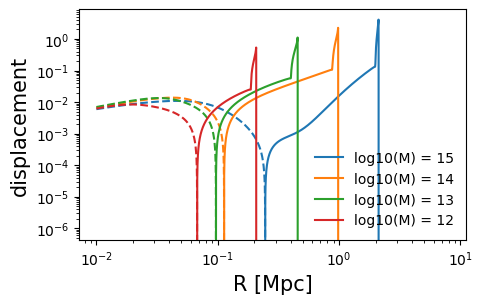

Baryonifying matter: 100%|██████████| 7088/7088 [00:40<00:00, 177.06it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.2
09:36:34
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.2
09:37:09


Building Table: 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


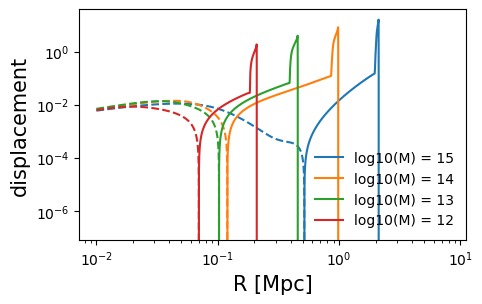

Baryonifying matter: 100%|██████████| 7088/7088 [00:39<00:00, 181.50it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.6
09:38:53
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.6
09:39:10


Building Table: 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]


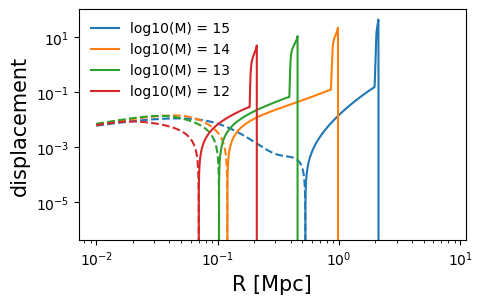

Baryonifying matter: 100%|██████████| 7088/7088 [00:37<00:00, 191.03it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 1.5
09:40:43
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 1.5
09:41:00


Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


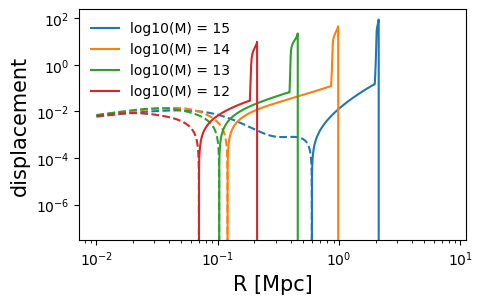

Baryonifying matter: 100%|██████████| 7088/7088 [00:38<00:00, 185.49it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 3.0
09:42:38
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 3.0
09:42:56


In [13]:
RES_eta = {'DM' : {}}

for param in [0.2, 0.6, 1.5, 3.0]:
    
    RES_eta[param] = {}
    
    tmp = copy.deepcopy(bpar)
    tmp['eta'] = param
    DMO = bfg.Profiles.Arico20.DarkMatterOnly(**tmp)
    DMB = bfg.Profiles.Arico20.DarkMatterBaryon(**tmp)

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfg.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = 2)
    Displacement.setup_interpolator(z_min = 0, z_max = 0.01, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 20_000, verbose = True, Rdelta_sampling = True)
    
    #Plot to show
    R = np.geomspace(0.01, 8, 10_000)
    plt.figure(figsize = (5,3)); plt.loglog()
    for M in [1e15, 1e14, 1e13, 1e12]: 
        c = plt.plot(R, Displacement.displacement(R, M, 1), label = 'log10(M) = %d' % np.log10(M))
        plt.plot(R, -Displacement.displacement(R, M, 1),color = c[0].get_color(), ls = '--')
    
    plt.ylabel('displacement', size = 15); plt.xlabel('R [Mpc]', size = 15); plt.legend(frameon = False)
    plt.show()
    
    #Swap in the new model into the Snapshot runner
    #And run the map!
    Runner.model    = Displacement
    Baryonified_Map = Runner.process()
    
    #Baryonified particle set
    Part_B = np.array([Baryonified_Map[x][:] for x in 'xyz']).T
    del Baryonified_Map; gc.collect()

    for factor in [1, 8]:

        Lbox = Snap.L / factor
        bins = np.linspace(0, Lbox, Ngrd + 1)
        
        MapB = numba_histogram3d(Part_B % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
        FFTB = np.fft.fftn(MapB); del MapB; gc.collect()
        FFTB = (np.conjugate(FFTB) * FFTB).real.flatten()
        PkB  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTB[kmsk]) / k_c; del FFTB; gc.collect()
        
        if f'Factor{factor}' not in RES_eta['DM'].keys():
            MapD = numba_histogram3d(Part_D % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
            FFTD = np.fft.fftn(MapD);  del MapD; gc.collect()
            FFTD = (np.conjugate(FFTD) * FFTD).real.flatten()
            PkD  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTD[kmsk]) / k_c; del FFTD; gc.collect()
            RES_eta['DM'][f'Factor{factor}'] = PkD
            
        else:
            PkD = RES_eta['DM'][f'Factor{factor}']

        
        RES_eta[param][f'Factor{factor}'] = {'k' : k_cen * factor, 'S' : PkB/PkD}
        
        print(f"FINISHED P(k) WITH FOLDING FACTOR {factor} FOR PARAM VALUE {param}")
        print(time.strftime("%H:%M:%S", time.localtime()))
        
    del Part_B; gc.collect()

Text(0.5, 0, '$k$  [$\\rm 1/Mpc$]')

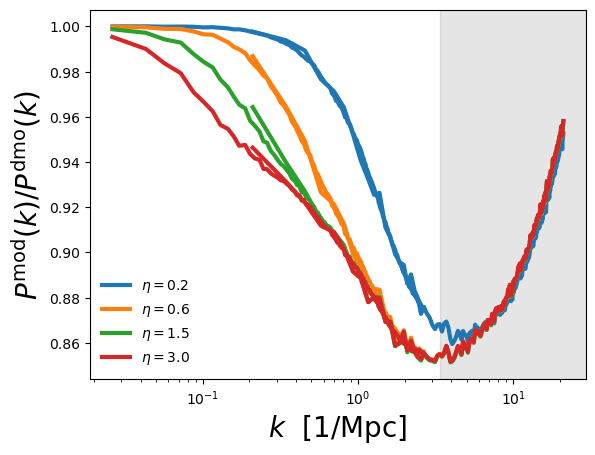

In [14]:
plt.xscale('log')

keys = [k for k in RES_eta.keys() if not isinstance(k, str)]
for i in range(len(keys)):
    R = RES_eta[keys[i]]
    for k in R.keys():
        plt.plot(R[k]['k'], R[k]['S'], color = f'C{i}', lw = 3, 
                 label = r'$\eta = %0.1f$' % keys[i] if k == list(R.keys())[0] else None)
    
    R = str(keys[i])[1:].replace('.', 'p')
    
xlim = plt.xlim()
plt.axvspan(5*h, xlim[1], color = 'k', alpha = 0.1); plt.xlim(xlim)
plt.legend(frameon = False)
plt.ylabel(r'$P^{\rm mod}(k)/P^{\rm dmo}(k)$', size = 20)
plt.xlabel(r'$k$  [$\rm 1/Mpc$]', size = 20)

# Now run for changes in theta_inn

Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


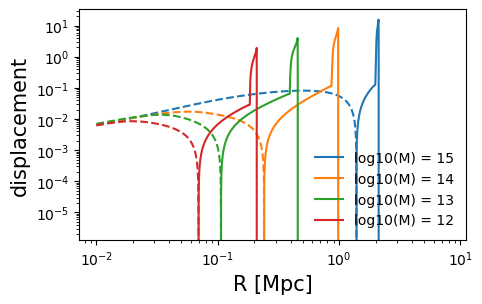

Baryonifying matter: 100%|██████████| 7088/7088 [00:39<00:00, 180.48it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.01
09:44:44
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.01
09:45:20


Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


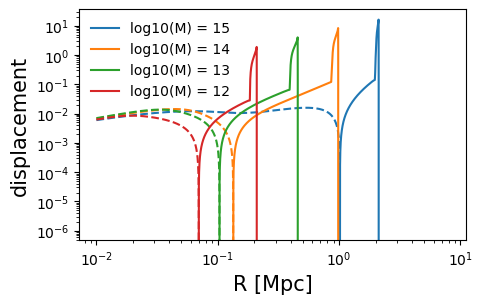

Baryonifying matter: 100%|██████████| 7088/7088 [00:38<00:00, 182.76it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.07
09:46:54
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.07
09:47:12


Building Table: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]


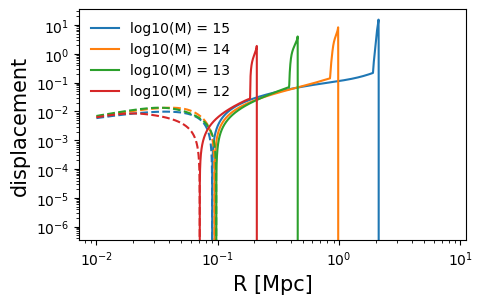

Baryonifying matter: 100%|██████████| 7088/7088 [00:39<00:00, 180.72it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.5
09:49:01
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.5
09:49:19


Building Table: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]


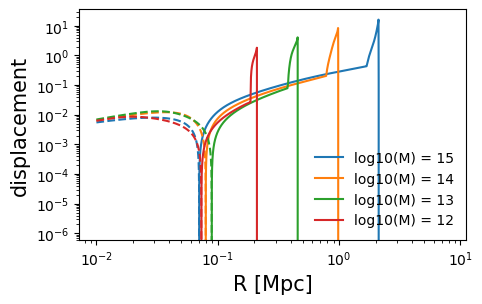

Baryonifying matter: 100%|██████████| 7088/7088 [00:39<00:00, 179.84it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 3.2
09:51:03
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 3.2
09:51:23


In [15]:
RES_Tinn = {'DM' : {}}

for param in [0.01, 0.07, 0.5, 3.2]:
    
    RES_Tinn[param] = {}
    
    tmp = copy.deepcopy(bpar)
    tmp['theta_inn'] = param
    DMO = bfg.Profiles.Arico20.DarkMatterOnly(**tmp)
    DMB = bfg.Profiles.Arico20.DarkMatterBaryon(**tmp)

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfg.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = 2)
    Displacement.setup_interpolator(z_min = 0, z_max = 0.01, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 20_000, verbose = True, Rdelta_sampling = True)
    
    #Plot to show
    R = np.geomspace(0.01, 8, 10_000)
    plt.figure(figsize = (5,3)); plt.loglog()
    for M in [1e15, 1e14, 1e13, 1e12]: 
        c = plt.plot(R, Displacement.displacement(R, M, 1), label = 'log10(M) = %d' % np.log10(M))
        plt.plot(R, -Displacement.displacement(R, M, 1),color = c[0].get_color(), ls = '--')
    
    plt.ylabel('displacement', size = 15); plt.xlabel('R [Mpc]', size = 15); plt.legend(frameon = False)
    plt.show()
    
    #Swap in the new model into the Snapshot runner
    #And run the map!
    Runner.model    = Displacement
    Baryonified_Map = Runner.process()
    
    #Baryonified particle set
    Part_B = np.array([Baryonified_Map[x][:] for x in 'xyz']).T
    del Baryonified_Map; gc.collect()

    for factor in [1, 8]:

        Lbox = Snap.L / factor
        bins = np.linspace(0, Lbox, Ngrd + 1)
        
        MapB = numba_histogram3d(Part_B % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
        FFTB = np.fft.fftn(MapB); del MapB; gc.collect()
        FFTB = (np.conjugate(FFTB) * FFTB).real.flatten()
        PkB  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTB[kmsk]) / k_c; del FFTB; gc.collect()
        
        if f'Factor{factor}' not in RES_Tinn['DM'].keys():
            MapD = numba_histogram3d(Part_D % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
            FFTD = np.fft.fftn(MapD);  del MapD; gc.collect()
            FFTD = (np.conjugate(FFTD) * FFTD).real.flatten()
            PkD  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTD[kmsk]) / k_c; del FFTD; gc.collect()
            RES_Tinn['DM'][f'Factor{factor}'] = PkD
            
        else:
            PkD = RES_Tinn['DM'][f'Factor{factor}']

        
        RES_Tinn[param][f'Factor{factor}'] = {'k' : k_cen * factor, 'S' : PkB/PkD}
        
        print(f"FINISHED P(k) WITH FOLDING FACTOR {factor} FOR PARAM VALUE {param}")
        print(time.strftime("%H:%M:%S", time.localtime()))
        
    del Part_B; gc.collect()

Text(0.5, 0, '$k$  [$\\rm 1/Mpc$]')

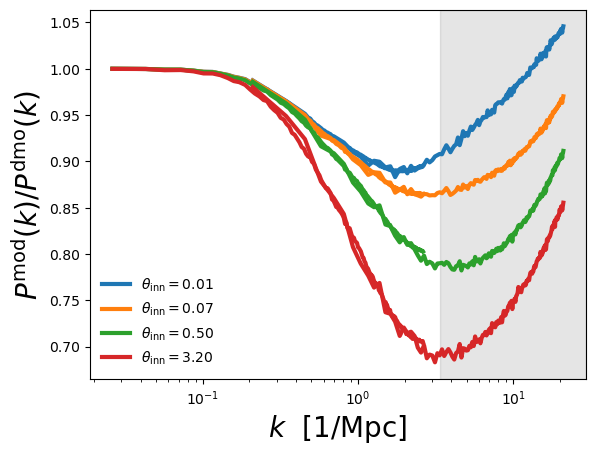

In [16]:
plt.xscale('log')

keys = [k for k in RES_Tinn.keys() if not isinstance(k, str)]
for i in range(len(keys)):
    R = RES_Tinn[keys[i]]
    for k in R.keys():
        plt.plot(R[k]['k'], R[k]['S'], color = f'C{i}', lw = 3, 
                 label = r'$\theta_{\rm inn} = %0.2f$' % keys[i] if k == list(R.keys())[0] else None)
        
xlim = plt.xlim()
plt.axvspan(5*h, xlim[1], color = 'k', alpha = 0.1); plt.xlim(xlim)
plt.legend(frameon = False)
plt.ylabel(r'$P^{\rm mod}(k)/P^{\rm dmo}(k)$', size = 20)
plt.xlabel(r'$k$  [$\rm 1/Mpc$]', size = 20)

# Now run for changes in beta

Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


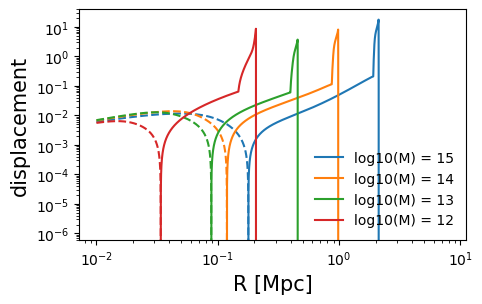

Baryonifying matter: 100%|██████████| 7088/7088 [00:40<00:00, 176.94it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.1
10:01:36
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.1
10:02:12


Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


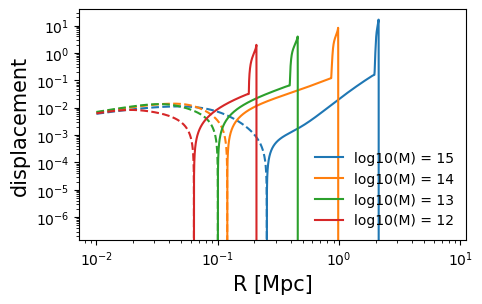

Baryonifying matter: 100%|██████████| 7088/7088 [00:38<00:00, 185.40it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.5
10:03:47
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.5
10:04:05


Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


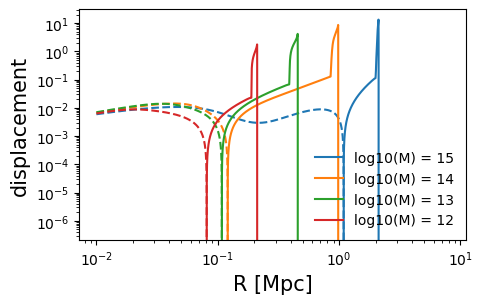

Baryonifying matter: 100%|██████████| 7088/7088 [00:39<00:00, 181.06it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 1
10:05:48
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 1
10:06:06


Building Table: 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


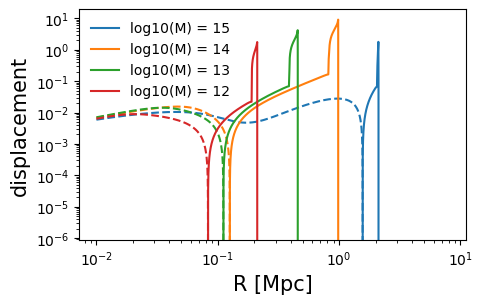

Baryonifying matter: 100%|██████████| 7088/7088 [00:38<00:00, 184.25it/s]


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 5
10:07:52
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 5
10:08:09


In [19]:
RES_beta = {'DM' : {}}

for param in [0.1, 0.5, 1, 5]:
    
    RES_beta[param] = {}
    
    tmp = copy.deepcopy(bpar)
    tmp['beta'] = param
    DMO = bfg.Profiles.Arico20.DarkMatterOnly(**tmp)
    DMB = bfg.Profiles.Arico20.DarkMatterBaryon(**tmp)

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfg.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = 2)
    Displacement.setup_interpolator(z_min = 0, z_max = 0.01, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 20_000, verbose = True, Rdelta_sampling = True)
    
    #Plot to show
    R = np.geomspace(0.01, 8, 10_000)
    plt.figure(figsize = (5,3)); plt.loglog()
    for M in [1e15, 1e14, 1e13, 1e12]: 
        c = plt.plot(R, Displacement.displacement(R, M, 1), label = 'log10(M) = %d' % np.log10(M))
        plt.plot(R, -Displacement.displacement(R, M, 1),color = c[0].get_color(), ls = '--')
    
    plt.ylabel('displacement', size = 15); plt.xlabel('R [Mpc]', size = 15); plt.legend(frameon = False)
    plt.show()
    
    #Swap in the new model into the Snapshot runner
    #And run the map!
    Runner.model    = Displacement
    Baryonified_Map = Runner.process()
    
    #Baryonified particle set
    Part_B = np.array([Baryonified_Map[x][:] for x in 'xyz']).T
    del Baryonified_Map; gc.collect()

    for factor in [1, 8]:

        Lbox = Snap.L / factor
        bins = np.linspace(0, Lbox, Ngrd + 1)
        
        MapB = numba_histogram3d(Part_B % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
        FFTB = np.fft.fftn(MapB); del MapB; gc.collect()
        FFTB = (np.conjugate(FFTB) * FFTB).real.flatten()
        PkB  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTB[kmsk]) / k_c; del FFTB; gc.collect()
        
        if f'Factor{factor}' not in RES_beta['DM'].keys():
            MapD = numba_histogram3d(Part_D % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
            FFTD = np.fft.fftn(MapD);  del MapD; gc.collect()
            FFTD = (np.conjugate(FFTD) * FFTD).real.flatten()
            PkD  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTD[kmsk]) / k_c; del FFTD; gc.collect()
            RES_beta['DM'][f'Factor{factor}'] = PkD
            
        else:
            PkD = RES_beta['DM'][f'Factor{factor}']

        
        RES_beta[param][f'Factor{factor}'] = {'k' : k_cen * factor, 'S' : PkB/PkD}
        
        print(f"FINISHED P(k) WITH FOLDING FACTOR {factor} FOR PARAM VALUE {param}")
        print(time.strftime("%H:%M:%S", time.localtime()))
        
    del Part_B; gc.collect()

Text(0.5, 0, '$k$  [$\\rm 1/Mpc$]')

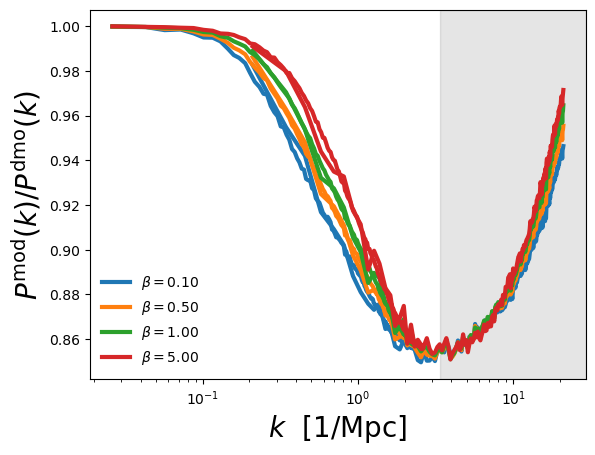

In [20]:
plt.xscale('log')

keys = [k for k in RES_beta.keys() if not isinstance(k, str)]
for i in range(len(keys)):
    R = RES_beta[keys[i]]
    for k in R.keys():
        plt.plot(R[k]['k'], R[k]['S'], color = f'C{i}', lw = 3, 
                 label = r'$\beta = %0.2f$' % keys[i] if k == list(R.keys())[0] else None)
        
xlim = plt.xlim()
plt.axvspan(5*h, xlim[1], color = 'k', alpha = 0.1); plt.xlim(xlim)
plt.legend(frameon = False)
plt.ylabel(r'$P^{\rm mod}(k)/P^{\rm dmo}(k)$', size = 20)
plt.xlabel(r'$k$  [$\rm 1/Mpc$]', size = 20)

## Some brief caveats about this comparison


In contrast to the similar comparison done for the Schneider19 model (see Example 10 in this repo) the comparison in this notebook is only illustrative and not quantitative. We unfortunately do not have all the necessary information (particularly, regarding the fiducial param values) to reproduce Figure 6 in [Arico2020](https://arxiv.org/pdf/2009.14225). So at best, this example above shows that the variations of P(k) across parameter values approximately mimics that found in the aforementioned Figure 6.